In [8]:
import inspect
import numpy as np
import numbers
import redis
import graphviz

numpy example can be found [here](https://numpy.org/doc/stable/reference/generated/numpy.lib.mixins.NDArrayOperatorsMixin.html) and [here](https://numpy.org/doc/stable/user/basics.dispatch.html).

In [146]:
class Variable(np.lib.mixins.NDArrayOperatorsMixin):
    _HANDLED_TYPES = (np.ndarray, numbers.Number)
    def __init__(self, value):
        self.value = np.asarray(value)
        self.id = id(self)
        self._type = type(value)
        self._unit = None
        self._creation = []
        self._modification = []
        self._use = []
        self._parent = dict()
        self._children = dict()
        inspect_res = inspect.stack()
        hrchy = self._process_stack(inspect_res)
        if hrchy[0] == "__init__":
            self._creation = [__name__] + hrchy[1:]
            
        self._db = redis.Redis()
        self._db_connected = self._db.ping()
        
    def _register_parents(self, parents, operation, function):
        parentkey = ":".join([str(self.id), "parent"])
        parentstr = "-".join([str(x) for x in parents])
        parentstr = ":".join([parentstr, operation, function])
        _ = self._db.set(parentkey, parentstr)
    
    def _register_children(self, children, operation, function):
        childkey = ":".join([str(self.id), "children"])
        childstr = "-".join([str(x) for x in children])
        childstr = ":".join([childstr, operation, function])
        if self._db.exists(childkey):
            childstr = "#".join([self._db.get(childkey).decode("utf-8"), childstr])
        _ = self._db.set(childkey, childstr)        
    
    def _process_stack(self, inspect_res):
        hrchy = []
        for res in inspect_res:
            if res[3][0] == "<":
                break
            hrchy.append(res[3])
        return hrchy

    def __array_ufunc__(self, ufunc, method, *inputs, **kwargs):
        
        out = kwargs.get('out', ())
        
        for x in inputs + out:
            if not isinstance(x, self._HANDLED_TYPES + (Variable,)):
                return NotImplemented
        
        inputs_tuple = tuple(x.value if isinstance(x, Variable) else x
                       for x in inputs)
        if out:
            kwargs['out'] = tuple(
                x.value if isinstance(x, Variable) else x
                for x in out)
        result = getattr(ufunc, method)(*inputs_tuple, **kwargs)

        inspect_res = inspect.stack()
        hrchy = self._process_stack(inspect_res)
        if len(hrchy)>2:
            origin = ".".join(hrchy[2:])
        else:
            origin = "__main__"
        
        if type(result) is tuple:
            return_results = tuple(type(self)(x) for x in result)
            for ret in return_results:
                for inp in inputs:
                    inp._register_children([id(ret) for ret in return_results], 
                                            ufunc.__name__, origin)                
                ret._register_parents([id(inp) for inp in inputs], 
                                        ufunc.__name__, origin)
            return return_results
        
        elif method == 'at':
            return None
        else:
            return_result = type(self)(result)
            for inp in inputs:
                inp._register_children([id(return_result)], 
                                        ufunc.__name__, origin)                
            return_result._register_parents([id(inp) for inp in inputs], 
                                        ufunc.__name__, origin)
            return return_result
    
    def _get_parents(self):
        return get_parents(str(self.id), self._db)
    
    def _build_graph(self, dot):
        op_dict = {}
        dot.node(str(self.id), style='filled', fillcolor='#C0CA33')
        return build_graph(str(self.id), dot, self._db, op_dict)
    
    def inspect(self):
        dot = graphviz.Digraph()
        dot = self._build_graph(dot)
        return dot
    
    def __repr__(self):
        return '%s(%r)' % (type(self).__name__, self.value)
    
    
    
def get_parents(idstr, db):
    parentstr = db.get(f"{idstr}:parent")
    if parentstr is None:
        return None, None, None
    else:
        parentstr = parentstr.decode("utf-8")
        raw = parentstr.split(":")
        function = raw[2]
        operation = raw[1]
        parents = raw[0].split("-")
        return parents, operation, function

def build_graph(idstr, dot, db, op_count_dict):
    parents, operation, function = get_parents(idstr, db)
    
    if parents is None:
        return dot

    if operation in op_count_dict.keys():
        operation_name = operation + "#" + str(op_count_dict[operation]) + f"[{function}]"
        op_count_dict[operation] += 1
    else:
        op_count_dict[operation] = 1
        operation_name = operation + "#0" + f"[{function}]"
            
    dot.node(operation_name, shape="box", style="filled", color="#F9A825")
    dot.edge(operation_name, str(idstr), color="#37474F")
    
    for parent in parents:
        dot.node(parent)
        dot.edge(parent, operation_name, color="#37474F")
        dot = build_graph(parent, dot, db, op_count_dict)
    return dot


In [147]:
def create_vars():
    a = Variable([1,2,3,4])
    b = Variable(2)
    x = a*b
    return x

In [148]:
create_vars()

Variable(array([2, 4, 6, 8]))

In [155]:
a = Variable([1,2,3,4])
b = Variable(2)

In [158]:
x = create_vars()

In [159]:
y = a-b

In [160]:
z = x*y

In [161]:
dot = z.inspect()

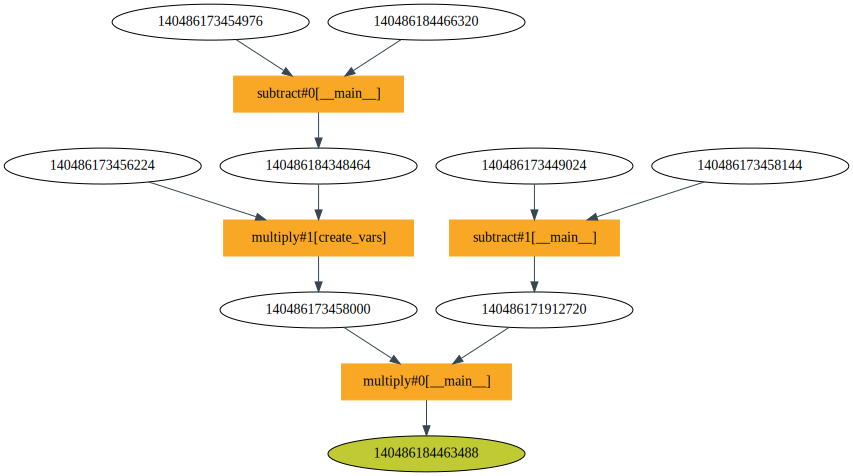

In [162]:
dot

In [6]:
db = redis.Redis()

In [16]:
db.get(f"{str(z.id)}:parent").decode("utf-8")

'140487963048784-140487963369120:multiply'

In [25]:
db.get(f"{str(a.id)}:parent").decode("utf-8")

AttributeError: 'NoneType' object has no attribute 'decode'